<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/tests/Matrix_Completion_using_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# PyTorch version of basic MF (vanilla GD only)
class MF_Torch:
    def __init__(self, X_np, k, alpha, beta, iterations, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.X = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

        self.num_users, self.num_items = self.X.shape
        self.mask = ~torch.isnan(self.X)

        self.U = torch.randn(self.num_users, k, device=self.device) * 0.01
        self.V = torch.randn(self.num_items, k, device=self.device) * 0.01
        self.b_u = torch.zeros(self.num_users, device=self.device)
        self.b_v = torch.zeros(self.num_items, device=self.device)
        self.b = torch.nanmean(self.X)

        self.observed_idx = torch.nonzero(self.mask, as_tuple=False)

    def predict(self):
        return self.b + self.b_u[:, None] + self.b_v[None, :] + torch.matmul(self.U, self.V.T)

    def train(self):
        history = []
        for it in range(self.iterations):
            torch.random.manual_seed(it)
            self._sgd_step()
            loss = self.compute_loss()
            history.append((it, loss))
            if (it + 1) % 20 == 0:
                print(f"Iteration {it+1}/{self.iterations}, Error: {loss:.4f}")
        return history

    def _sgd_step(self):
        for idx in torch.randperm(len(self.observed_idx)):
            i, j = self.observed_idx[idx]
            x = self.X[i, j]
            pred = self.predict()[i, j]
            e = x - pred

            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            grad_U = 2 * e * self.V[j] - self.beta * self.U[i]
            grad_V = 2 * e * self.U[i] - self.beta * self.V[j]

            self.U[i] += self.alpha * grad_U
            self.V[j] += self.alpha * grad_V

    def compute_loss(self):
        pred = self.predict()
        return torch.mean((self.X[self.mask] - pred[self.mask]) ** 2).item()

    def full_matrix(self):
        return self.predict().detach().cpu().numpy()

    def replace_nan(self, X_hat_np, X_np):
        X_complete = np.copy(X_np)
        X_complete[np.isnan(X_complete)] = X_hat_np[np.isnan(X_complete)]
        return X_complete


In [ ]:
class MF_NQM_Torch:
    def __init__(self, X_np, k, alpha=1e-4, beta=0.01, iterations=100,
                 noise_var=1e-5, momentum=0.8, ema_beta=0.9, update_strategy='vanilla', device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        X_tensor = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        self.X = X_tensor
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.noise_var = noise_var
        self.momentum = momentum
        self.ema_beta = ema_beta
        self.update_strategy = update_strategy

        self.num_users, self.num_items = self.X.shape
        self.mask = ~torch.isnan(self.X)

        self.U = torch.randn(self.num_users, k, device=self.device) * 0.01
        self.V = torch.randn(self.num_items, k, device=self.device) * 0.01
        self.b_u = torch.zeros(self.num_users, device=self.device)
        self.b_v = torch.zeros(self.num_items, device=self.device)
        self.b = torch.nanmean(self.X)

        self.U_momentum = torch.zeros_like(self.U)
        self.V_momentum = torch.zeros_like(self.V)
        self.U_ema = torch.zeros_like(self.U)
        self.V_ema = torch.zeros_like(self.V)

        self.observed_idx = torch.nonzero(self.mask, as_tuple=False)

    def predict(self):
        return self.b + self.b_u[:, None] + self.b_v[None, :] + torch.matmul(self.U, self.V.T)

    def train(self):
        history = []
        for it in range(self.iterations):
            self._sgd_step()
            error = self.compute_loss()
            history.append((it, error))
            if (it + 1) % 10 == 0:
                print(f"Iteration {it+1}/{self.iterations}, MSE: {error:.4f}")
        return history

    def _sgd_step(self):
        max_grad = 3.0
        param_bound = 10.0
        for idx in torch.randperm(len(self.observed_idx)):
            i, j = self.observed_idx[idx]
            x = self.X[i, j]
            pred = self.predict()[i, j]
            e = x - pred

            grad_U = 2 * e * self.V[j] - self.beta * self.U[i]
            grad_V = 2 * e * self.U[i] - self.beta * self.V[j]

            grad_U = torch.clamp(grad_U, -max_grad, max_grad)
            grad_V = torch.clamp(grad_V, -max_grad, max_grad)

            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            noise_u = torch.randn_like(grad_U) * self.noise_var**0.5
            noise_v = torch.randn_like(grad_V) * self.noise_var**0.5

            if self.update_strategy == 'vanilla':
                self.U[i] += self.alpha * grad_U + noise_u
                self.V[j] += self.alpha * grad_V + noise_v
            elif self.update_strategy == 'momentum':
                self.U_momentum[i] = self.momentum * self.U_momentum[i] + self.alpha * grad_U
                self.V_momentum[j] = self.momentum * self.V_momentum[j] + self.alpha * grad_V
                self.U[i] += self.U_momentum[i] + noise_u
                self.V[j] += self.V_momentum[j] + noise_v
            elif self.update_strategy == 'ema':
                self.U_ema[i] = self.ema_beta * self.U_ema[i] + (1 - self.ema_beta) * grad_U
                self.V_ema[j] = self.ema_beta * self.V_ema[j] + (1 - self.ema_beta) * grad_V
                # self.U_ema[i, :] = torch.clamp(self.U_ema[i, :], -max_grad, max_grad)
                # self.V_ema[j, :] = torch.clamp(self.V_ema[j, :], -max_grad, max_grad)

                self.U[i] += self.U_ema[i] + noise_u
                self.V[j] += self.V_ema[j] + noise_v

            self.U[i, :] = torch.clamp(self.U[i, :], -param_bound, param_bound)
            self.V[j, :] = torch.clamp(self.V[j, :], -param_bound, param_bound)

            if torch.isnan(e) or torch.any(torch.isnan(self.U[i])) or torch.any(torch.isnan(self.V[j])):
                print("NaN detected")


    def compute_loss(self):
        pred = self.predict()
        return F.mse_loss(pred[self.mask], self.X[self.mask]).item()

    def full_matrix(self):
        return self.predict().detach().cpu().numpy()

    def replace_nan(self, X_hat_np, X_np):
        X_complete = np.copy(X_np)
        X_complete[np.isnan(X_complete)] = X_hat_np[np.isnan(X_complete)]
        return X_complete


In [ ]:
class MF_Adam(nn.Module):
    def __init__(self, X, k):
        super().__init__()
        self.device = X.device
        self.X = X
        self.k = k

        self.m, self.n = X.shape

        # Latent factors
        self.U = nn.Parameter(torch.randn(self.m, k, device=self.device) * 0.01)
        self.V = nn.Parameter(torch.randn(self.n, k, device=self.device) * 0.01)

        # Bias terms
        self.b_u = nn.Parameter(torch.zeros(self.m, device=self.device))
        self.b_v = nn.Parameter(torch.zeros(self.n, device=self.device))

        # Global bias
        mean_value = torch.nanmean(X).item()
        self.b = nn.Parameter(torch.tensor(mean_value, dtype=torch.float32, device=self.device))

        # Create observation mask
        self.mask = ~torch.isnan(X)  # True where value is observed

    def forward(self):
        pred = self.b + self.b_u[:, None] + self.b_v[None, :] + self.U @ self.V.T
        return pred

    def masked_loss(self):
        pred = self.forward()
        return ((self.X[self.mask] - pred[self.mask]) ** 2).mean()

    def full_matrix(self):
        return self.forward().detach()

    def replace_nan(self, pred_matrix):
        X_copy = self.X.clone().detach()
        X_copy[~self.mask] = pred_matrix[~self.mask]
        return X_copy

    def train_and_evaluate(X_scaled, X_original, k=5, epochs=300, lr=1e-3, wd=1e-4):
        device = X_scaled.device
        model = MF_Adam(X_scaled, k).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        history = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = model.masked_loss()
            loss.backward()
            optimizer.step()
            history.append((epoch, loss.item()))

        X_hat = model.full_matrix()
        X_hat = X_hat * torch.max(X_scaled[~torch.isnan(X_scaled)])
        X_comp = model.replace_nan(X_hat)

        X_np = torch.tensor(X_original, dtype=torch.float32, device=X_hat.device)
        mask = ~torch.isnan(X_np)

        mse = F.mse_loss(X_hat[mask], X_np[mask]).item()
        rmse = mse ** 0.5
        mae = torch.mean(torch.abs(X_hat[mask] - X_np[mask])).item()

        return history, X_hat.cpu().numpy(), X_comp.cpu().numpy(), mse, rmse, mae


In [ ]:
def generate_low_rank_matrix(n1, n2, r, noise_std=1e-4, observed_ratio=0.2):
    M = np.random.randn(n1, r) @ np.random.randn(r, n2)
    df = r * (n1 + n2 - r)
    m = min(6 * df, round(observed_ratio * n1 * n2))
    # p = 3 * m / (n1 * n2)
    Omega = np.random.choice(n1 * n2, m, replace=False)
    data = M.flatten()[Omega]
    data += noise_std * np.random.randn(*data.shape)

    X = np.full((n1, n2), np.nan)
    X.flat[Omega] = data
    print(f"Generated matrix: {n1}x{n2}, rank {r}, observed {100*p:.1f}%")
    return X, M

def evaluate(X_original, X_hat):
    observed = ~np.isnan(X_original)
    y_true = X_original[observed]
    y_pred = X_hat[observed]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return round(mse, 4), round(rmse, 4), round(mae, 4)

In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    torch.manual_seed(42)

    n1, n2, r = 100, 100, 3
    X, M_true = generate_low_rank_matrix(n1, n2, r)
    X_scaled = X / np.nanmax(X)
    X_scaled = torch.tensor(X_scaled, dtype=torch.float32, device=device)

    all_histories = {}
    all_metrics = []
    strategies = ['sgd', 'vanilla', 'momentum', 'ema', 'adam']

    # --------------------- Basic MF Torch ---------------------
    print("\n[SGD without noisy]")
    mf = MF_Torch(X_scaled, k=3, alpha=5e-5, beta=0.05, iterations=300)
    # mf = mf.to(device)
    sgd_hist = mf.train()
    sgd_hat = mf.full_matrix() * np.nanmax(X)
    sgd_comp = mf.replace_nan(sgd_hat, X)
    mse, rmse, mae = evaluate(X, sgd_hat)

    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

    all_histories["SGD"] = sgd_hist
    all_metrics.append({"Strategy": strategies[0], "MSE": mse, "RMSE": rmse, "MAE": mae})


Generated matrix: 100x100, rank 3, observed 60.0%

[SGD without noisy]


<ipython-input-19-daabb01e9485>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_np, dtype=torch.float32, device=self.device)


Iteration 20/300, Error: 0.0392
Iteration 40/300, Error: 0.0389
Iteration 60/300, Error: 0.0386
Iteration 80/300, Error: 0.0383
Iteration 100/300, Error: 0.0381
Iteration 120/300, Error: 0.0378
Iteration 140/300, Error: 0.0376
Iteration 160/300, Error: 0.0374
Iteration 180/300, Error: 0.0372
Iteration 200/300, Error: 0.0371
Iteration 220/300, Error: 0.0369
Iteration 240/300, Error: 0.0368
Iteration 260/300, Error: 0.0367
Iteration 280/300, Error: 0.0365
Iteration 300/300, Error: 0.0364
MSE: 2.7064, RMSE: 1.6451, MAE: 1.1775


In [ ]:
 # --------------------- NQM Torch (all strategies) ---------------------
if __name__ == "__main__":
    for strat in strategies[1:4]:
        print(f"\n[{strat.upper()}]")
        model = MF_NQM_Torch(X_scaled, k=3, alpha=5e-5, beta=0.05,
                             iterations=300, update_strategy=strat)
        # model = model.to(device)
        hist = model.train()
        X_hat = model.full_matrix() * np.nanmax(X)
        X_comp = model.replace_nan(X_hat, X)
        mse, rmse, mae = evaluate(X, X_hat)

        print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}\n")

        all_histories[strat] = hist
        all_metrics.append({"Strategy": strat, "MSE": mse, "RMSE": rmse, "MAE": mae})



[VANILLA]


<ipython-input-20-97a43714863b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_np, dtype=torch.float32, device=self.device)


Iteration 10/300, MSE: 0.0394
Iteration 20/300, MSE: 0.0394
Iteration 30/300, MSE: 0.0394
Iteration 40/300, MSE: 0.0393
Iteration 50/300, MSE: 0.0394
Iteration 60/300, MSE: 0.0395
Iteration 70/300, MSE: 0.0396
Iteration 80/300, MSE: 0.0397
Iteration 90/300, MSE: 0.0401
Iteration 100/300, MSE: 0.0398
Iteration 110/300, MSE: 0.0399
Iteration 120/300, MSE: 0.0399
Iteration 130/300, MSE: 0.0404
Iteration 140/300, MSE: 0.0405
Iteration 150/300, MSE: 0.0405
Iteration 160/300, MSE: 0.0408
Iteration 170/300, MSE: 0.0411
Iteration 180/300, MSE: 0.0416
Iteration 190/300, MSE: 0.0418
Iteration 200/300, MSE: 0.0419
Iteration 210/300, MSE: 0.0423
Iteration 220/300, MSE: 0.0424
Iteration 230/300, MSE: 0.0430
Iteration 240/300, MSE: 0.0437
Iteration 250/300, MSE: 0.0439
Iteration 260/300, MSE: 0.0443
Iteration 270/300, MSE: 0.0445
Iteration 280/300, MSE: 0.0457
Iteration 290/300, MSE: 0.0471
Iteration 300/300, MSE: 0.0479
MSE: 3.5592, RMSE: 1.8866, MAE: 1.4303


[MOMENTUM]


<ipython-input-20-97a43714863b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_np, dtype=torch.float32, device=self.device)


Iteration 10/300, MSE: 0.0394
Iteration 20/300, MSE: 0.0392
Iteration 30/300, MSE: 0.0390
Iteration 40/300, MSE: 0.0390
Iteration 50/300, MSE: 0.0389
Iteration 60/300, MSE: 0.0387
Iteration 70/300, MSE: 0.0386
Iteration 80/300, MSE: 0.0387
Iteration 90/300, MSE: 0.0387
Iteration 100/300, MSE: 0.0388
Iteration 110/300, MSE: 0.0388
Iteration 120/300, MSE: 0.0388
Iteration 130/300, MSE: 0.0389
Iteration 140/300, MSE: 0.0387
Iteration 150/300, MSE: 0.0386
Iteration 160/300, MSE: 0.0389
Iteration 170/300, MSE: 0.0391
Iteration 180/300, MSE: 0.0394
Iteration 190/300, MSE: 0.0393
Iteration 200/300, MSE: 0.0393
Iteration 210/300, MSE: 0.0392
Iteration 220/300, MSE: 0.0393
Iteration 230/300, MSE: 0.0397
Iteration 240/300, MSE: 0.0399
Iteration 250/300, MSE: 0.0400
Iteration 260/300, MSE: 0.0398
Iteration 270/300, MSE: 0.0400
Iteration 280/300, MSE: 0.0403
Iteration 290/300, MSE: 0.0409
Iteration 300/300, MSE: 0.0410
MSE: 3.0446, RMSE: 1.7449, MAE: 1.2919


[EMA]


<ipython-input-20-97a43714863b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_np, dtype=torch.float32, device=self.device)


Iteration 10/300, MSE: 0.0129
Iteration 20/300, MSE: 0.0139
Iteration 30/300, MSE: 76.0408
Iteration 40/300, MSE: 97.8962
Iteration 50/300, MSE: 93.2606
Iteration 60/300, MSE: 103.2905
Iteration 70/300, MSE: 116.2210
Iteration 80/300, MSE: 92.7788
Iteration 90/300, MSE: 103.4339
Iteration 100/300, MSE: 117.4251
Iteration 110/300, MSE: 166.9857
Iteration 120/300, MSE: 144.4149
Iteration 130/300, MSE: 149.5718
Iteration 140/300, MSE: 161.7008
Iteration 150/300, MSE: 95.3708
Iteration 160/300, MSE: 95.0063
Iteration 170/300, MSE: 110.4159
Iteration 180/300, MSE: 93.1216
Iteration 190/300, MSE: 124.7035
Iteration 200/300, MSE: 136.6732
Iteration 210/300, MSE: 89.7100
Iteration 220/300, MSE: 192.2510
Iteration 230/300, MSE: 88.0603
Iteration 240/300, MSE: 148.9382
Iteration 250/300, MSE: 82.5963
Iteration 260/300, MSE: 155.0345
Iteration 270/300, MSE: 125.8585
Iteration 280/300, MSE: 127.2914
Iteration 290/300, MSE: 157.9825
Iteration 300/300, MSE: 152.6757
MSE: 11340.0155, RMSE: 106.4895, 

In [ ]:
if __name__ == "__main__":
    # --------------------- MF_Adam ---------------------
    print("\n[ADAM]")

    adam_hist, X_hat, X_comp, mse, rmse, mae = MF_Adam.train_and_evaluate(
        X_scaled, X, k=3, epochs=300, lr=5e-5, wd=1e-4
    )

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    all_histories['adam'] = adam_hist
    all_metrics.append({
        "Strategy": "adam",
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    })



[ADAM]
MSE: 2.9237, RMSE: 1.7099, MAE: 1.2219


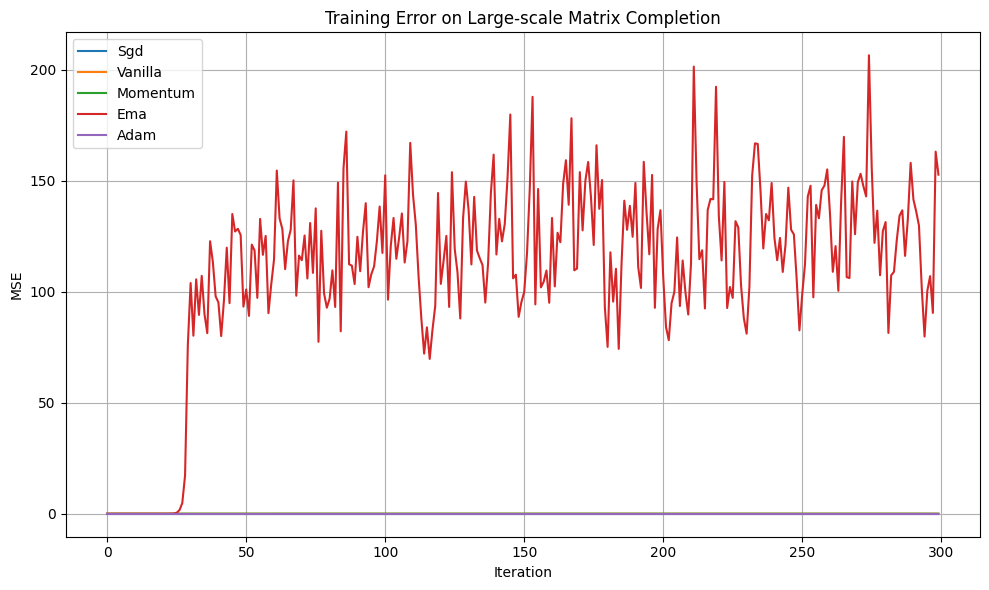

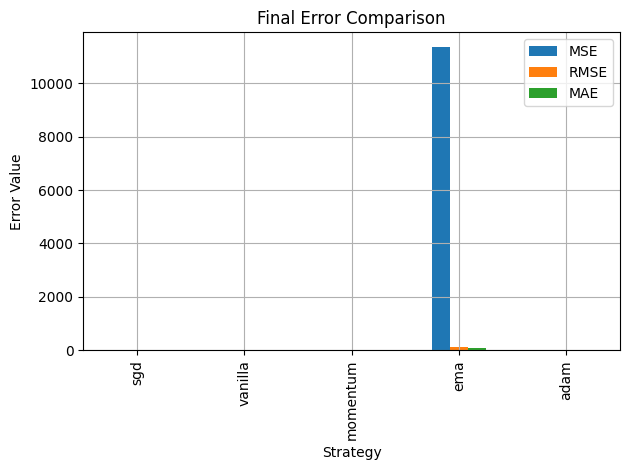


Final Metrics:
Strategy        MSE     RMSE     MAE
     sgd     2.7064   1.6451  1.1775
 vanilla     3.5592   1.8866  1.4303
momentum     3.0446   1.7449  1.2919
     ema 11340.0155 106.4895 71.2022
    adam     2.9237   1.7099  1.2219


In [ ]:
# --------------------- Plot Training Curves ---------------------
if __name__ == "__main__":
    plt.figure(figsize=(10, 6))

    for strat, hist in all_histories.items():
        iters, errors = zip(*hist)
        plt.plot(iters, errors, label=strat.capitalize())

    plt.title("Training Error on Large-scale Matrix Completion")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Final Errors ---------------------
    df_metrics = pd.DataFrame(all_metrics)

    df_metrics.plot(x='Strategy', y=['MSE', 'RMSE', 'MAE'], kind='bar')
    plt.title("Final Error Comparison")
    plt.ylabel("Error Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nFinal Metrics:")
    print(df_metrics.round(4).to_string(index=False))


In [ ]:
print(all_histories)

{'SGD': [(0, 0.03956528380513191), (1, 0.03954663500189781), (2, 0.039528071880340576), (3, 0.03950958698987961), (4, 0.0394911915063858), (5, 0.039472874253988266), (6, 0.039454638957977295), (7, 0.03943647816777229), (8, 0.03941841050982475), (9, 0.039400409907102585), (10, 0.03938249498605728), (11, 0.039364662021398544), (12, 0.039346903562545776), (13, 0.039329227060079575), (14, 0.03931162878870964), (15, 0.039294108748435974), (16, 0.039276666939258575), (17, 0.039259303361177444), (18, 0.03924201428890228), (19, 0.03922480717301369), (20, 0.03920767456293106), (21, 0.03919060900807381), (22, 0.03917362540960312), (23, 0.0391567163169384), (24, 0.03913988173007965), (25, 0.03912312537431717), (26, 0.03910643979907036), (27, 0.03908982500433922), (28, 0.039073292165994644), (29, 0.03905682638287544), (30, 0.03904043883085251), (31, 0.03902411833405495), (32, 0.039007872343063354), (33, 0.038991693407297134), (34, 0.03897559270262718), (35, 0.0389595590531826), (36, 0.038943596184

In [ ]:
all_histories = {k: v for k, v in all_histories.items() if 'ema' not in k.lower()}
all_metrics = [entry for entry in all_metrics if 'ema' not in entry['Strategy'].lower()]


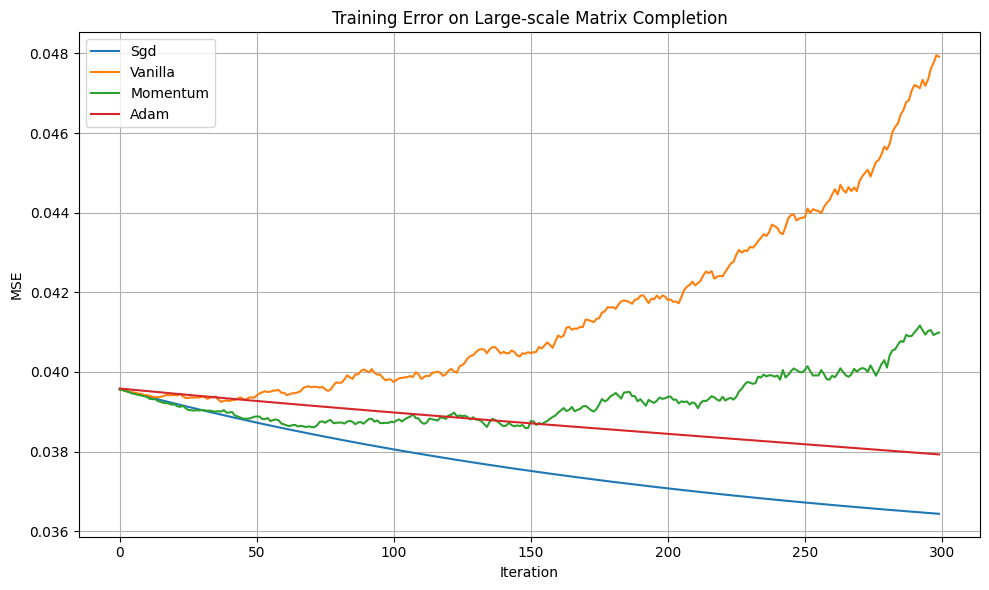

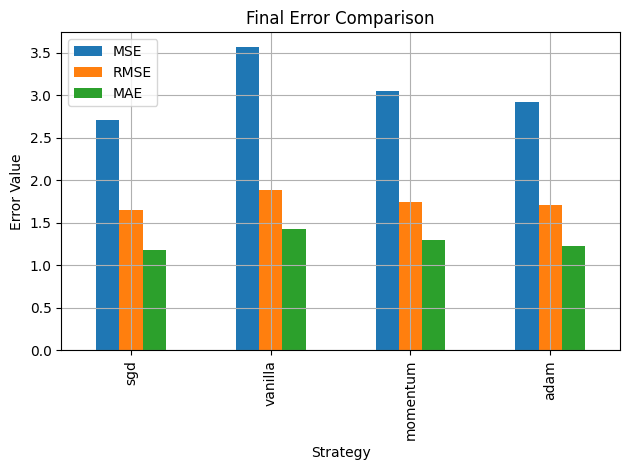


Final Metrics:
Strategy    MSE   RMSE    MAE
     sgd 2.7064 1.6451 1.1775
 vanilla 3.5592 1.8866 1.4303
momentum 3.0446 1.7449 1.2919
    adam 2.9237 1.7099 1.2219


In [ ]:
if __name__ == "__main__":
    plt.figure(figsize=(10, 6))

    for strat, hist in all_histories.items():
        iters, errors = zip(*hist)
        plt.plot(iters, errors, label=strat.capitalize())

    plt.title("Training Error on Large-scale Matrix Completion")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Final Errors ---------------------
    df_metrics = pd.DataFrame(all_metrics)

    df_metrics.plot(x='Strategy', y=['MSE', 'RMSE', 'MAE'], kind='bar')
    plt.title("Final Error Comparison")
    plt.ylabel("Error Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nFinal Metrics:")
    print(df_metrics.round(4).to_string(index=False))
